# VGG model to classify images

In [2]:
import pandas as pd 
from keras.utils import image_dataset_from_directory
from keras.layers import Dense, Flatten
from keras.applications import VGG16
import os 


2023-05-23 15:26:47.276328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 15:26:47.417250: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 15:26:48.058862: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-23 15:26:48.058907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

# Import pictures

Filter dataset according to desired nb of images per species

In [3]:
PATH_TO_DATASET ="/home/basile/Documents/projet_bees_detection_basile/bees_detection/src/datafiles/final_datafiles/dataset_yolo_cropped_with_cleaned_structure.csv"

def filter_dataset(only_species=True, min_images=None,hierarchy=False,df_dataset=None):
    """
    Filter the dataset according to specified criteria. 
    Parameters
    ---------------
    only_species : keep only the pictures labelled in picture level
    min_images : keep only the taxa that have more than x images
    path_to_dataset : dataset to filter in csv
            # Path #Labels

    Returns 
    --------------
    df_dataset : filtered dataset # Paths # Labels
    species : species in filtered dataset # Specie # Nb_img

    """


    # Take only the images labelled as species (i.e. real labels has more than 1 word)
    if only_species:
        df_dataset = df_dataset[df_dataset["Labels"].str.contains(" ")]
  
    # Get the number of species that have more than min_images images
    if min_images is not None : 

        species = df_dataset['Labels'].value_counts()[df_dataset['Labels'].value_counts() > min_images]

        # Convert the series to a dataframe
        species = species.to_frame()

        # Reset the index
        species.reset_index(inplace=True)

        # Rename the columns
        species.columns = ['Species', 'Number of images']

        # Filter the dataset
        df_dataset = df_dataset[df_dataset["Labels"].isin(species["Species"])]

        print("Number of species with more than {} images : {}".format(min_images, len(species)))
        print("Number of images in the filtered dataset : {}".format(len(df_dataset)))

        print('-'*50)
        print(df_dataset['Labels'].value_counts())

    return df_dataset, species

df_dataset=pd.read_csv(PATH_TO_DATASET)
dataset, species = filter_dataset(only_species=True, min_images=20000,
                                      df_dataset=df_dataset)

Number of species with more than 20000 images : 2
Number of images in the filtered dataset : 69628
--------------------------------------------------
Apis mellifera       49093
Bombus terrestris    20535
Name: Labels, dtype: int64


Keep only 20000 images of each of those two species

In [4]:
# cap to 20000 images per species
dataset = dataset.groupby('Labels').head(200).reset_index(drop=True)

In [5]:
# split into train and test and validation sets
from sklearn.model_selection import train_test_split


train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=0)

In [6]:
# # split train test val keeping the same distribution of species
# nb_train = int(len(dataset)*0.8)
# nb_test = int(len(dataset)*0.1)
# nb_val = int(len(dataset)*0.1)

# train = dataset.groupby('Labels').head(nb_train).reset_index(drop=True)
# test = dataset.groupby('Labels').head(nb_test).reset_index(drop=True)
# val = dataset.groupby('Labels').head(nb_val).reset_index(drop=True)

# create folder for train test val
path = "/home/basile/Documents/projet_bees_detection_basile/data_bees_detection/VGG_2_species/"


if os.path.exists(path):
    print("Path already exists")
    import shutil
    shutil.rmtree(path)

os.mkdir(path)



Path already exists


In [7]:
# make dirs for each species
train_dataset.to_csv(path+"train_dataset.csv",index=False)
test_dataset.to_csv(path+"test_dataset.csv",index=False)
val_dataset.to_csv(path+"val_dataset.csv",index=False)

species = train_dataset['Labels'].unique().tolist()

folders = ["train","test","val"]

for folder in folders:

    if not os.path.exists(os.path.join(path,folder)):
        os.mkdir(os.path.join(path,folder))
    

    for specie in species:

        os.mkdir(os.path.join(path,folder,specie))

In [8]:
# copy images to proper folder
import shutil

for folder in folders:
    for specie in species:
        df = pd.read_csv(path+folder+"_dataset.csv")
        df = df[df["Labels"]==specie]
        for index, row in df.iterrows():
            shutil.copy(row["Paths"],os.path.join(path,folder,specie))
            

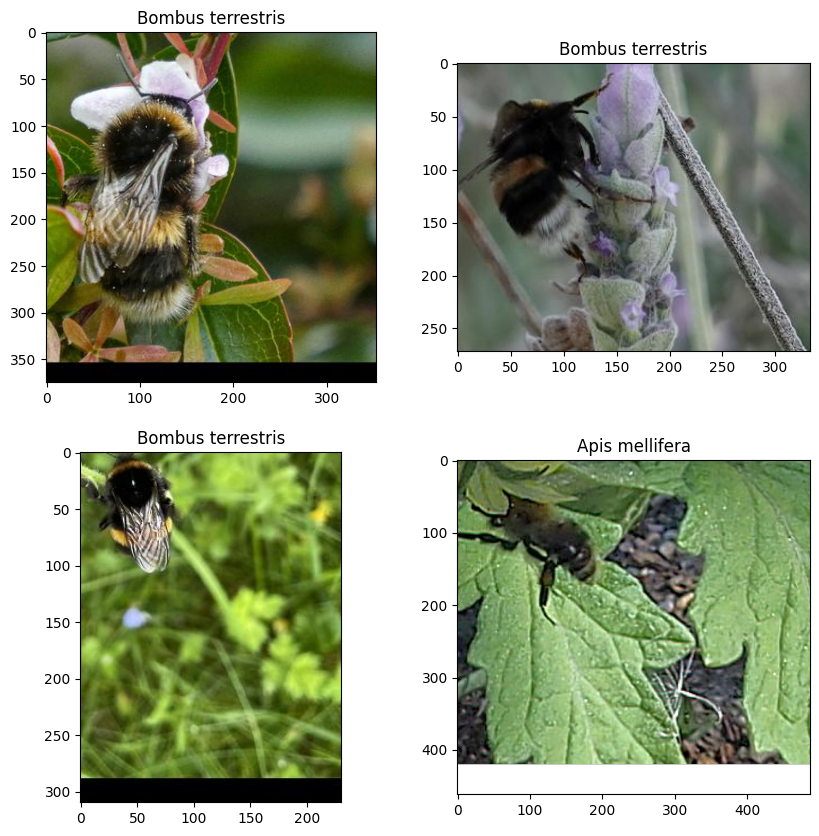

In [9]:
# checkout some images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

folders = ["train","test","val"]

plt.figure(figsize=(10,10))

for i in range(4): 

    # get a random file in path
    specie = np.random.choice(species)
    folder = np.random.choice(folders)
    path_to_img = np.random.choice(os.listdir(os.path.join(path,folder,specie)))

    # plot it
    plt.subplot(2,2,i+1)
    img = mpimg.imread(os.path.join(path,folder,specie,path_to_img))
    plt.title(specie)

    plt.imshow(img)

In [10]:
# create dataset for keras
path = "/home/basile/Documents/projet_bees_detection_basile/data_bees_detection/VGG_2_species"


train_dataset = image_dataset_from_directory(os.path.join(path,"train"), shuffle=True, batch_size=32, image_size=(128,128),labels = 'inferred',label_mode= 'categorical')
test_dataset = image_dataset_from_directory(os.path.join(path,"test"), shuffle=True, batch_size=32, image_size=(128,128),labels = 'inferred',label_mode= 'categorical')
val_dataset = image_dataset_from_directory(os.path.join(path,"val" ),shuffle=True, batch_size=32, image_size=(128,128),labels = 'inferred',label_mode= 'categorical')

Found 256 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Found 64 files belonging to 2 classes.


2023-05-23 15:26:50.579988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 15:26:50.595471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 15:26:50.595680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 15:26:50.596725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [11]:
# get min max mean and std of images in train dataset

import numpy as np

def get_min_max_mean_std(dataset):

    min = 255
    max = 0
    mean = 0
    std = 0

    for image_batch, labels_batch in dataset:

        min = np.min([min,np.min(image_batch)])
        max = np.max([max,np.max(image_batch)])
        mean += np.mean(image_batch)
        std += np.std(image_batch)

    mean = mean/len(dataset)
    std = std/len(dataset)

    return min, max, mean, std

min, max, mean, std = get_min_max_mean_std(train_dataset)

print("Min : {}".format(min))
print("Max : {}".format(max))
print("Mean : {}".format(mean))
print("Std : {}".format(std))


Min : 0.0
Max : 255.0
Mean : 93.65749263763428
Std : 72.88318634033203


# Preprocess inputs and create Sequence object

In [12]:
import numpy as np

x_train = np.array(train_dataset.file_paths)
y_train = np.zeros((len(x_train),len(train_dataset.class_names)))

ind_data = 0
for bx, by in train_dataset.as_numpy_iterator():
  y_train[ind_data:ind_data+bx.shape[0]] = by
  ind_data += bx.shape[0]

def color_preprocessing(x):
    x = x.astype('float32')
    mean = [125.3, 123.0, 113.9]
    std  = [63.0,  62.1,  66.7]
    for i in range(3):
        x[:,:,:,i] = (x[:,:,:,i] - mean[i]) / std[i]
    return x

In [13]:
from keras.utils import Sequence
import numpy as np
import cv2 as cv

CLASS_NAMES = train_dataset.class_names

class AbeillesSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_train, y_train, batch_size):
        self.x_train = x_train
        self.y_train = y_train
        self.classes = CLASS_NAMES
        self.batch_size = batch_size
        self.indices1 = np.arange(len(x_train))

        np.random.shuffle(self.indices1)
        # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(x_train.shape[0] / float(self.batch_size)))
   
    def _read_img(self, img_path):
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        return img

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    # idx = position du batch (idx = 5 => on prend le 5ème batch)
    def __getitem__(self, idx):
        # Sélection des données : batch x correspond aux filepath
        batch_x = self.x_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]

        # Lecture des images
        batch_x = np.array([self._read_img(file_name) for file_name in batch_x])

    
        # Normalisation des données
        batch_x = color_preprocessing(batch_x)
        
        return batch_x, batch_y

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)

In [14]:
class AbeillesSequence2(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_train, y_train, batch_size,class_names,image_size):
        self.x_train = x_train
        self.y_train = y_train
        self.classes = class_names
        self.batch_size = batch_size
        self.image_size = image_size
        self.indices1 = np.arange(len(x_train))

        np.random.shuffle(self.indices1)
        # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(self.x_train.shape[0] / float(self.batch_size)))
   
    def _read_img(self, img_path):
        
        img = cv.imread(img_path)
        # resize
        img = cv.resize(img,(self.image_size,self.image_size))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)


        return img

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    # idx = position du batch (idx = 5 => on prend le 5ème batch)
    def __getitem__(self, idx):
        # Sélection des données : batch x correspond aux filepath
        batch_x = self.x_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]

        # Lecture des images
        batch_x = np.array([self._read_img(file_name) for file_name in batch_x])

    
        # Normalisation des données
        batch_x = color_preprocessing(batch_x)
        
        return batch_x, batch_y

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)

# Make VGG16 model

In [15]:
# Create classification layer 
# create conv base
import keras
import tensorflow as tf

conv_base = VGG16( include_top=False, input_shape=(128, 128, 3))

nb_classes = 2

flatten_layer = keras.layers.Flatten()(conv_base.output)
dense_layer = keras.layers.Dense(128, activation='relu')(flatten_layer)
output_layer = keras.layers.Dense(nb_classes, activation='softmax')(dense_layer)

# Define new model
from keras.models import Model

model = Model(inputs=conv_base.input, outputs=output_layer)

# Compile the model
OSS = 'binary_crossentropy'
OPTI = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
METRICS = ['binary_accuracy']

model.compile(loss=OSS, optimizer=OPTI, metrics=METRICS)

2023-05-23 15:27:01.653268: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.00MiB (rounded to 9437184)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-23 15:27:01.653318: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-05-23 15:27:01.653323: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 34, Chunks in use: 34. 8.5KiB allocated for chunks. 8.5KiB in use in bin. 701B client-requested in use in bin.
2023-05-23 15:27:01.653326: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2023-05-23 15:27:01.653329: I tensorflow/tsl/fram

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
# # add callbacks

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=1, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=3, verbose=1)
checkpoint = ModelCheckpoint('vgg16_2_species.h5', monitor='val_binary_accuracy', verbose=1, save_best_only=True, save_weights_only=False)

# callbacks = [early_stopping, reduce_lr, checkpoint]

callbacks = [checkpoint]


In [ ]:
import numpy as np
import tensorflow as tf
# Normalisation des données de validation
x_val = np.zeros((len(val_dataset.file_paths), 128, 128, 3))
y_val = np.zeros((len(val_dataset.file_paths), len(val_dataset.class_names)))

ind_data = 0
for bx, by in val_dataset.as_numpy_iterator():
  x_val[ind_data:ind_data+bx.shape[0]] = bx
  y_val[ind_data:ind_data+bx.shape[0]] = by
  ind_data += bx.shape[0]

x_val = color_preprocessing(x_val)

In [ ]:
x_val.shape

(64, 128, 128, 3)

In [ ]:
min, max, mean, std = np.min(x_val), np.max(x_val), np.mean(x_val), np.std(x_val)

print("Min : {}".format(min))
print("Max : {}".format(max))
print("Mean : {}".format(mean))
print("Std : {}".format(std))


Min : -1.9888889789581299
Max : 2.1256039142608643
Mean : -0.4713172912597656
Std : 1.1134687662124634


In [ ]:
class_names = train_dataset.class_names

ds_train = AbeillesSequence2(x_train, y_train, batch_size=8,class_names=class_names,image_size=128)

In [ ]:

# fit model
history = model.fit(train_dataset, epochs=100, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks)

Epoch 1/100


2023-05-23 15:08:07.905678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-05-23 15:08:08.127004: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-23 15:08:08.127031: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-23 15:08:08.128622: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 317.53MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if

NotFoundError: Graph execution error:

Detected at node 'model/block1_conv1/Relu' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/basile/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/basile/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/basile/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/basile/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4530/3163841497.py", line 2, in <module>
      history = model.fit(train_dataset, epochs=100, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/home/basile/.local/lib/python3.10/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/basile/.local/lib/python3.10/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'model/block1_conv1/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 0#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 2#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1098914560 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1098914560 bytes.
  Profiling failure on CUDNN engine 6#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 6: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 5#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(5150): 'status'
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 332950528 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 332950528 bytes.
	 [[{{node model/block1_conv1/Relu}}]] [Op:__inference_train_function_3533]

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.677752,0.554688,0.818470,0.5
1,0.663498,0.585938,1.176117,0.5
2,0.680484,0.558594,1.269827,0.5
3,0.676230,0.554688,1.523003,0.5
4,0.666625,0.609375,3.572715,0.5


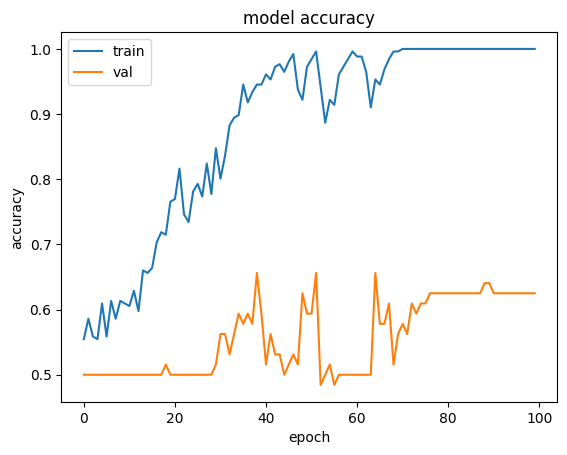

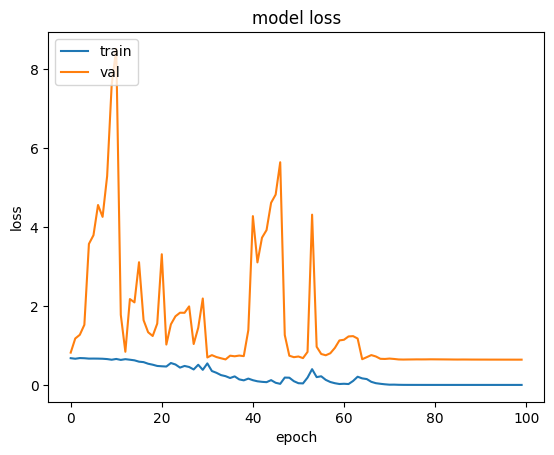

In [ ]:
# plot loss and accuracy

import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()


In [ ]:
x_test = np.zeros((len(test_dataset.file_paths), 128, 128, 3))
y_test = np.zeros((len(test_dataset.file_paths), len(test_dataset.class_names)))

ind_data = 0
for bx, by in test_dataset.as_numpy_iterator():
  x_test[ind_data:ind_data+bx.shape[0]] = bx
  y_test[ind_data:ind_data+bx.shape[0]] = by
  ind_data += bx.shape[0]

x_test= color_preprocessing(x_test)

In [ ]:
# evaluate model

model.evaluate(x_test, y_test, verbose=1)


3/3 [==============================] - 0s 103ms/step - loss: 0.7177 - binary_accuracy: 0.6250


[0.7177330255508423, 0.625]

In [ ]:
# predict on random image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# get a random file in path
